In [15]:
import pandas as pd 
import numpy as np 

In [16]:
filename = './stock.csv'

In [17]:
dataset = pd.read_csv(filename)
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


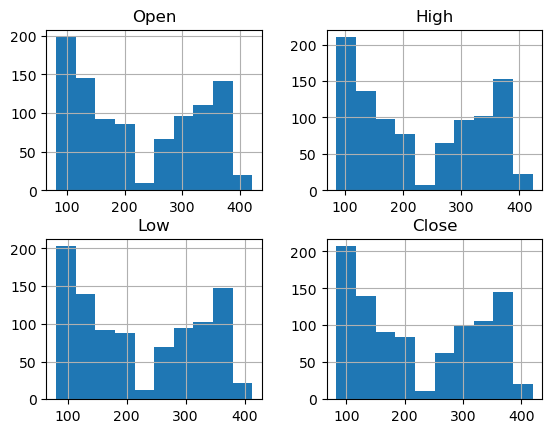

In [18]:
import matplotlib.pyplot as plt 

data_used = dataset.iloc[:, 1:4]

data_used['Close'] = dataset['Close']

hist = data_used.hist()
plt.show()


- [3] 학습용 데이터셋 준비

In [19]:
import numpy as np  
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [20]:
class StockDS(Dataset):  # 클래스 선언
    def __init__(self, filename):
        self.csvDF = pd.read_csv(filename)            # 데이터 읽기

        # 입력 데이터 정규화
        self.data = self.csvDF.iloc[:, 1:4].values                        # 종가 제외한 데이터
        self.data = self.data / np.max(self.data)                       # 0과 1 사이로 정규화

        # 종가 데이터 정규화
        self.label = self.csvDF["Close"].values         
        self.label = self.label / np.max(self.label)
        
    def __len__(self):
        return len(self.data) - 30                                  # 사용 가능한 배치 개수

    def __getitem__(self, i):
        data = self.data[i:i+30]                                        # 입력 데이터 30일치 읽기
        label = self.label[i+30]                                        # 다음 날 종가 데이터 

        return data, label


In [21]:
import torch
import torch.nn as nn


class StockRNN(nn.Module):
   def __init__(self):
       super(StockRNN, self).__init__()

       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)  # RNN층의 정의

       # 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)

       self.relu = nn.ReLU() # 활성화 함수 정의
        
   def forward(self, x, h0):
       x, hn = self.rnn(x, h0)  # RNN층의 출력

       # MLP층의 입력으로 사용될 수 있도록 모양 변경
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
      
       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

In [22]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = StockRNN().to(device)                         # 모델의 정의
dataset = StockDS(filename)                         # 데이터셋의 정의

In [23]:
loader = DataLoader(dataset, batch_size=32)         # 배치 크기 32로 설정

In [24]:
optim = Adam(params=model.parameters(), lr=0.0001)          # 최적화 설정

In [25]:
for epoch in range(50):
   iterator = tqdm.tqdm(loader)
   
   for data, label in iterator:
       optim.zero_grad()

       h0 = torch.zeros(5, data.shape[0], 8).to(device)
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
       
       
       loss.backward()
       optim.step()

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

epoch49 loss:0.004183186683803797: 100%|██████████| 30/30 [00:00<00:00, 49.04it/s]  


In [26]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())                                     # 예측값 리스트에 추가
       loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))     # 손실계산
       total_loss += loss/len(loader)                                   # 손실의 평균치 계산

total_loss.item()

0.002540209796279669

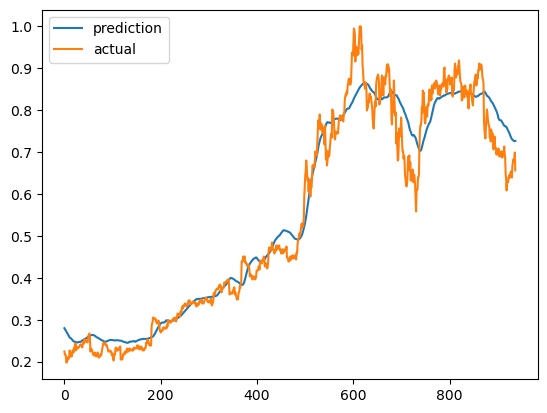

In [27]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()